## TUTORIAL 01 - Thermal block problem
**_Keywords: certified reduced basis method, scalar problem_**

### 1. Introduction
In this Tutorial, we consider steady heat conduction in a two-dimensional domain $\Omega$.

<img src="data/thermal_block.png" />

We define two subdomains $\Omega_1$ and $\Omega_2$, such that
1. $\Omega_1$ is a disk centered at the origin of radius $r_0=0.5$, and
2. $\Omega_2=\Omega/\ \overline{\Omega_1}$. 

The conductivity $\kappa$ is assumed to be constant on $\Omega_1$ and $\Omega_2$, i.e.
$$
\kappa|_{\Omega_1}=\kappa_0 \quad \textrm{and} \quad \kappa|_{\Omega_2}=1.
$$

For this problem, we consider $P=2$ parameters:
1. the first one is related to the conductivity in $\Omega_1$, i.e. $\mu_0\equiv k_0$ (_note that parameters numbering is zero-based_);
2. the second parameter $\mu_1$ takes into account the constant heat flux over $\Gamma_{base}$.

The parameter vector $\boldsymbol{\mu}$ is thus given by 
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
on the parameter domain
$$
\mathbb{P}=[0.1,10]\times[-1,1].
$$

In this problem we model the heat transfer process due to the heat flux over the bottom boundary $\Gamma_{base}$ and the following conditions on the remaining boundaries:
* the left and right boundaries $\Gamma_{side}$ are insulated,
* the top boundary $\Gamma_{top}$ is kept at a reference temperature (say, zero),

with the aim of measuring the average temperature on $\Gamma_{base}$.

In order to obtain a faster evaluation (yet, provably accurate) of the output of interest we propose to use a certified reduced basis approximation for the problem.

### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the temperature in the domain $\Omega$.

The strong formulation of the parametrized problem is given by:
<center>for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})$ such that</center>

$$
\begin{cases}
	- \text{div} (\kappa(\mu_0)\nabla u(\boldsymbol{\mu})) = 0 & \text{in } \Omega,\\
	u(\boldsymbol{\mu}) = 0 & \text{on } \Gamma_{top},\\
	\kappa(\mu_0)\nabla u(\boldsymbol{\mu})\cdot \mathbf{n} = 0 & \text{on } \Gamma_{side},\\
	\kappa(\mu_0)\nabla u(\boldsymbol{\mu})\cdot \mathbf{n} = \mu_1 & \text{on } \Gamma_{base}.
\end{cases}
$$
<br>

where 
* $\mathbf{n}$ denotes the outer normal to the boundaries $\Gamma_{side}$ and $\Gamma_{base}$,
* the conductivity $\kappa(\mu_0)$ is defined as follows:
$$
\kappa(\mu_0) =
\begin{cases}
	\mu_0 & \text{in } \Omega_1,\\
	1 & \text{in } \Omega_2,\\
\end{cases}
$$

The corresponding weak formulation reads:
<center>for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that</center>

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{v\in H^1(\Omega) : v|_{\Gamma_{top}}=0\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u, v;\boldsymbol{\mu})=\int_{\Omega} \kappa(\mu_0)\nabla u\cdot \nabla v \ d\boldsymbol{x},$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v; \boldsymbol{\mu})= \mu_1\int_{\Gamma_{base}}v \ ds.$$

The (compliant) output of interest $s(\boldsymbol{\mu})$ given by
$$s(\boldsymbol{\mu}) = \mu_1\int_{\Gamma_{base}} u(\boldsymbol{\mu})$$
is computed for each $\boldsymbol{\mu}$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

For this problem the affine decomposition is straightforward:
$$a(u,v;\boldsymbol{\mu})=\underbrace{\mu_0}_{\Theta^{a}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega_1}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_0(u,v)} \ + \  \underbrace{1}_{\Theta^{a}_1(\boldsymbol{\mu})}\underbrace{\int_{\Omega_2}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_1(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{\mu_1}_{\Theta^{f}_0(\boldsymbol{\mu})} \underbrace{\int_{\Gamma_{base}}v \ ds}_{f_0(v)}.$$
We will implement the numerical discretization of the problem in the class
```
class ThermalBlock(EllipticCoerciveCompliantProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):     
```
and the bilinear forms $a_*(u, v)$ and linear forms $f_*(v)$ in
```
    def assemble_operator(self, term):
```

In [2]:
class ThermalBlock(EllipticCoerciveCompliantProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveCompliantProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)

    # Return custom problem name
    def name(self):
        return "ThermalBlock"

    # Return the alpha_lower bound.
    def get_stability_factor_lower_bound(self):
        return min(self.compute_theta("a"))

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = mu[0]
            theta_a1 = 1.
            return (theta_a0, theta_a1)
        elif term == "f":
            theta_f0 = mu[1]
            return (theta_f0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = inner(grad(u), grad(v)) * dx(1)
            a1 = inner(grad(u), grad(v)) * dx(2)
            return (a0, a1)
        elif term == "f":
            ds = self.ds
            f0 = v * ds(1)
            return (f0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 3)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/thermal_block.xml")
subdomains = MeshFunction("size_t", mesh, "data/thermal_block_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/thermal_block_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the ThermalBlock class

In [5]:
problem = ThermalBlock(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.1, 10.0), (-1.0, 1.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a reduced basis method

In [6]:
reduction_method = PODGalerkin(problem)#ReducedBasis(problem)
reduction_method.set_Nmax(20)
reduction_method.set_tolerance(1e-10)#1e-5)

### 4.5. Perform the offline phase

In [7]:
reduction_method.initialize_training_set(100)
reduced_problem = reduction_method.offline()

### 4.5b Train the neural network

In [8]:
reduction_method.initialize_testing_set(100)
test_mu = torch.tensor(reduction_method.testing_set)

In [9]:
input_normalization_pinn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pinn = Normalization.StandardNormalization()

pinn_net  = NN.RONN(problem, reduction_method, n_neurons=20)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, optimizer, 
    suffix=pinn_loss.name(), by_validation=True
)

In [10]:
Training.normalize_and_train_pinn(
    pinn_net, data, pinn_loss, optimizer,
    input_normalization_pinn, epochs=10000, starting_epoch=starting_epoch
)

19800 2.1653553217332176e-06 	Loss(validation) = 0.0003201684421589933
19900 2.1460765780634348e-06 	Loss(validation) = 0.00031803754528396085
20000 7.751389048020403e-06 	Loss(validation) = 0.0003180593905442217
20100 2.116081769275687e-06 	Loss(validation) = 0.0003144043101608401
20200 2.0969009936419496e-06 	Loss(validation) = 0.0003123331942576875
20300 5.631510800795694e-06 	Loss(validation) = 0.00030825666771644195
20400 2.0687839652942133e-06 	Loss(validation) = 0.00030890178855944364
20500 2.0507967702481568e-06 	Loss(validation) = 0.0003069711407435498
20600 3.279505363035261e-05 	Loss(validation) = 0.00030776202237301354
20700 2.0277284426602754e-06 	Loss(validation) = 0.000304069728301438
20800 2.0116175008301866e-06 	Loss(validation) = 0.00030228792376958143
20900 1.9951421116346904e-06 	Loss(validation) = 0.00030041491756356597
21000 1.1298966908582952e-05 	Loss(validation) = 0.0003008760025741492
21100 1.968962117129967e-06 	Loss(validation) = 0.00029714420717869114
21200

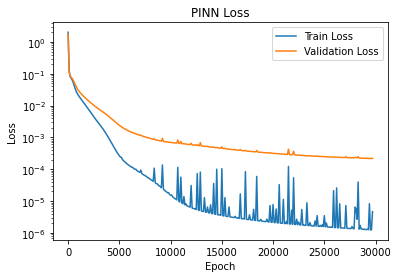

In [11]:
fig, ax = Training.plot_loss(pinn_net)

In [12]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_mu, input_normalization_pinn, output_normalization_pinn
)

Mean Relative Error:
N	NN-HF			NN-RO			RO-HF
4	0.005878684464831368	0.0058786854196173025	5.070341389591286e-07


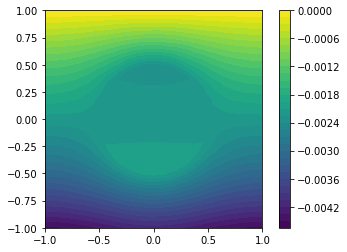

In [13]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, (8.0, -1.0), input_normalization_pinn, output_normalization_pinn
)

In [14]:
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN(problem, reduction_method, n_neurons=20)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, optimizer, 
    suffix=pdnn_loss.name(), by_validation=True
)

In [15]:
Training.normalize_and_train_pdnn(
    pdnn_net, data, pdnn_loss, optimizer,
    input_normalization_pdnn, epochs=10000, starting_epoch=starting_epoch
)

300 0.33434419897086354 	Loss(validation) = 0.68419463102944
400 0.2669816418331992 	Loss(validation) = 0.7132790679177319
500 0.22252733151079346 	Loss(validation) = 0.7790712678160608
600 0.18485537868235524 	Loss(validation) = 0.8556157150641642
700 0.15009277482504615 	Loss(validation) = 0.9269146980203281
800 0.11999695289635329 	Loss(validation) = 0.9813879511096397
900 0.09450027945992026 	Loss(validation) = 1.0165728518058912
1000 0.07298096234781334 	Loss(validation) = 1.0324987506699184
1100 0.05464054988326583 	Loss(validation) = 1.0302019840400476
1200 0.03888020790374934 	Loss(validation) = 1.0128769781835565
1300 0.026177361577758063 	Loss(validation) = 0.9928199757520622
1400 0.017020014976342333 	Loss(validation) = 0.9827573887574605
1500 0.010970254823226161 	Loss(validation) = 0.9867956433833772
1600 0.007152599793000369 	Loss(validation) = 0.9982949889396826
1700 0.004797319324369241 	Loss(validation) = 1.0095420818597982
1800 0.0033447752327161956 	Loss(validation) 

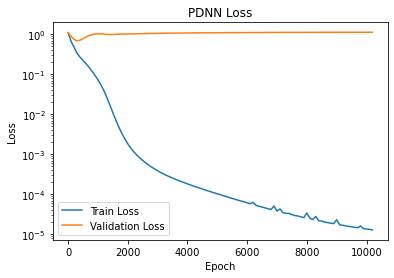

In [16]:
fig, ax = Training.plot_loss(pdnn_net)

In [17]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn
)

Mean Relative Error:
N	NN-HF			NN-RO			RO-HF
4	0.012205501159397758	0.012205501925801252	5.070341389591286e-07


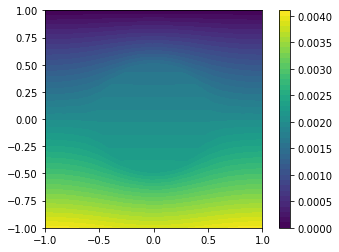

In [18]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, (8.0, -1.0), input_normalization_pdnn, output_normalization_pdnn
)

In [19]:
input_normalization_prnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_prnn = Normalization.StandardNormalization()

prnn_net  = NN.RONN(problem, reduction_method, n_neurons=20)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=1.)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, optimizer, 
    suffix=prnn_loss.name(), by_validation=True
)

In [20]:
Training.normalize_and_train_prnn(
    prnn_net, data, prnn_loss, optimizer,
    input_normalization_prnn, epochs=10000, starting_epoch=starting_epoch
)

3600 0.0020739050627862515 	Loss(validation) = 0.00486058526493076
3700 0.001845145498366922 	Loss(validation) = 0.0048681205379219284
3800 0.0016549081670397547 	Loss(validation) = 0.004886775807126717
3900 0.0014952707898433725 	Loss(validation) = 0.004914385529630145
4000 0.0013601603252700687 	Loss(validation) = 0.004949211429216203
4100 0.0012448082988314863 	Loss(validation) = 0.0049896953420015926
4200 0.0011454505279490737 	Loss(validation) = 0.005034510139411964
4300 0.0010591107562254924 	Loss(validation) = 0.005082356610691395
4400 0.0009834202691937771 	Loss(validation) = 0.005132289105366881
4500 0.0009165030654432111 	Loss(validation) = 0.005183167319566963
4600 0.0008568600998751503 	Loss(validation) = 0.005234210058155921
4700 0.0008032856745006073 	Loss(validation) = 0.005284442883638159
4800 0.0007548103673247839 	Loss(validation) = 0.00533324765396901
4900 0.0007111823862182782 	Loss(validation) = 0.005368514214220915
5000 0.0006702379216507685 	Loss(validation) = 0.

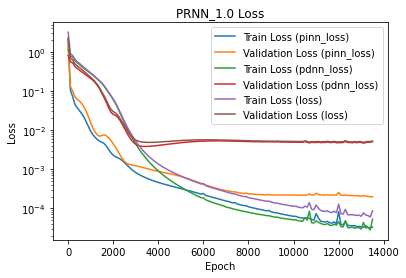

In [21]:
fig, ax = Training.plot_loss(prnn_net, separate=True)

In [22]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_mu, input_normalization_prnn, output_normalization_prnn
)

Mean Relative Error:
N	NN-HF			NN-RO			RO-HF
4	0.0071577392964258715	0.007157739438930144	5.070341389591286e-07


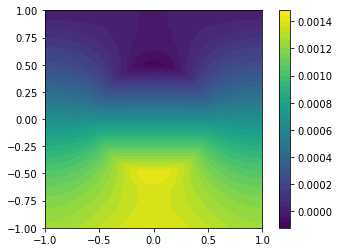

In [23]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, (8.0, -1.0), input_normalization_prnn, output_normalization_prnn
)

In [24]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_mu, input_normalizations, output_normalizations, euclidean=False
)

#####################################################################################
Mean Relative Error for 4 Basis Functions
Network		NN-HF			NN-RO			RO-HF
pinn_net	0.005878684464831368	0.0058786854196173025	5.070341389591286e-07
pdnn_net	0.012205501159397758	0.012205501925801252	5.070341389591286e-07
prnn_net	0.0071577392964258715	0.007157739438930144	5.070341389591286e-07
#####################################################################################


### 4.7. Perform an error analysis

In [ ]:
reduction_method.initialize_testing_set(100)
reduction_method.error_analysis()

### 4.8. Perform a speedup analysis

In [ ]:
reduction_method.initialize_testing_set(100)
reduction_method.speedup_analysis()